### Test web application locally
This notebook pulls some images and tests them against the local web app running inside the Docker container we made previously.

In [58]:
from testing_utilities import *
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
image_name='masalvar/tfresnet-gpu'

Run the Docker conatainer in the background and open port 88

In [46]:
%%bash --bg -s "$image_name"
nvidia-docker run -p 80:80 $1

Starting job # 0 in a separate thread.


Wait a few seconds for the application to spin up and then check that everything works

In [99]:
!curl 'http://0.0.0.0:80/version'

1.4.1

Pull an image of a plane to test our local web app with

In [100]:
IMAGEURL = "https://upload.wikimedia.org/wikipedia/commons/thumb/6/68/Lynx_lynx_poing.jpg/220px-Lynx_lynx_poing.jpg"

In [101]:
headers = {'content-type': 'application/json'}

In [102]:
jsonimg = img_url_to_json(IMAGEURL)
jsonimg[:100]  # Example of json string

'{"input": "[\\"iVBORw0KGgoAAAANSUhEUgAAAOAAAADgCAIAAACVT/22AAABJGlDQ1BJQ0MgUHJvZmlsZQAAeJxjYGAycHRxcm'

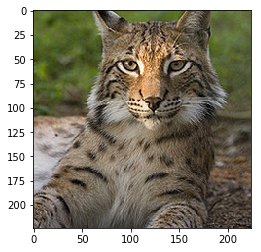

In [103]:
plt.imshow(to_img(IMAGEURL))

In [104]:
%time r = requests.post('http://0.0.0.0:80/score', data=jsonimg, headers=headers)
r.json()

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 2.09 s


{'result': [[['n02127052 lynx, catamount', 0.9974517226219177],
   ['n02128385 leopard, Panthera pardus', 0.001507689943537116],
   ['n02128757 snow leopard, ounce, Panthera uncia', 0.0005164744798094034]],
  'Computed in 2073.05 ms']}

Let's try a few more images

In [35]:
images = ('https://www.britishairways.com/assets/images/information/about-ba/fleet-facts/airbus-380-800/photo-gallery/240x295-BA-A380-exterior-2-high-res.jpg',
          'https://upload.wikimedia.org/wikipedia/commons/3/3a/Roadster_2.5_windmills_trimmed.jpg',
          'http://www.worldshipsociety.org/wp-content/themes/construct/lib/scripts/timthumb/thumb.php?src=http://www.worldshipsociety.org/wp-content/uploads/2013/04/stock-photo-5495905-cruise-ship.jpg&w=570&h=370&zc=1&q=100',
          'http://yourshot.nationalgeographic.com/u/ss/fQYSUbVfts-T7pS2VP2wnKyN8wxywmXtY0-FwsgxpiZv_E9ZfPsNV5B0ER8-bOdruvNfMD5EbP4SznWz4PYn/',
          'https://cdn.arstechnica.net/wp-content/uploads/2012/04/bohol_tarsier_wiki-4f88309-intro.jpg',
          'http://i.telegraph.co.uk/multimedia/archive/03233/BIRDS-ROBIN_3233998b.jpg')

In [36]:
url='http://0.0.0.0:80/score'
results = [requests.post(url, data=img_url_to_json(img), headers=headers) for img in images]

In [37]:
results[5].json()['result']

[[['n01530575 brambling, Fringilla montifringilla', 0.6734523177146912],
  ['n01807496 partridge', 0.06145329028367996],
  ['n01558993 robin, American robin, Turdus migratorius',
   0.04710515961050987]],
 'Computed in 48.83 ms']

In [38]:
results[5].json()['result'][0][0]

['n01530575 brambling, Fringilla montifringilla', 0.6734523177146912]

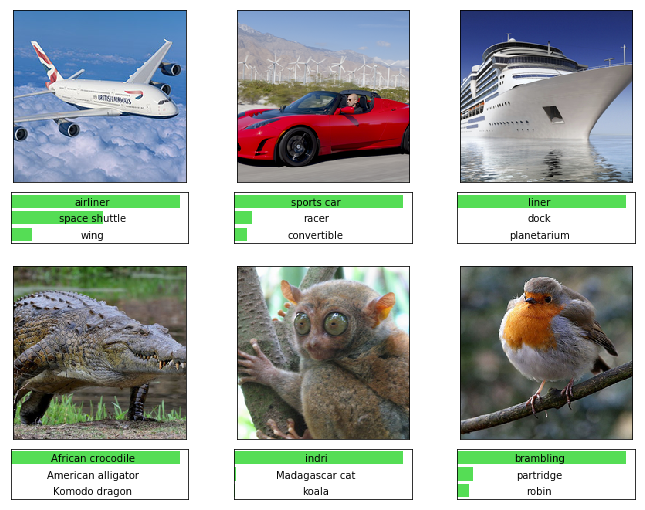

In [39]:
plot_predictions(images, results)

Next lets quickly check what the request response performance is for the locally running Docker container.

In [40]:
image_data = list(map(img_url_to_json, images)) # Retrieve the images and data

In [41]:
timer_results = list()
for img in image_data:
    res=%timeit -r 1 -o -q requests.post(url, data=img, headers=headers)
    timer_results.append(res.best)

In [42]:
timer_results

[0.04963331720791757,
 0.041110064997337756,
 0.03346498580649495,
 0.03363863059785217,
 0.03387461469974369,
 0.03435346179176122]

In [43]:
print('Average time taken: {0:4.2f} ms'.format(10**3 * np.mean(timer_results)))

Average time taken: 37.68 ms


Stop our Docker container

In [64]:
%%bash
docker stop $(docker ps -q)

b457161bb223


We can move onto [deploying our web application on ACS](DeployOnACS.ipynb)